In [2]:
# Imports
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor

# Set working directory
os.chdir('C:/Users/jzuyd/scgpt/scGPT')

# Change paths according to the location of scGPT, input data and faiss index directory
model_dir = "./data/scGPT_human"
gene_col = "index"
index_path = "./faiss_index/"
raw_data_path = "./data/CFS/CFS_all_days_rawcount.h5ad"
processed_data_path = "./data/CFS/CFS_all_days_processed.h5ad"
vocab_file = os.path.join(model_dir, "vocab.json")
generated_data_path = "./data/EXPRESSION_WITH_MT_RP.h5ad"

c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# Load data
raw_data = sc.read_h5ad(raw_data_path)
processed_data = sc.read_h5ad(processed_data_path)

# Define the days of interest
days = ['CFS_Day0', 'CFS_Day2', 'CFS_Day14', 'CFS_Day28']

# Initialize lists to store the subsets for each day
raw_subsets = []
processed_subsets = []

# Subset 1000 cells from each day
for day in days:
    subset_raw = raw_data[raw_data.obs['sample'] == day].copy()
    subset_processed = processed_data[processed_data.obs['sample'] == day].copy()
    
    # Sample 1000 cells if more than 1000 are available, otherwise use all available cells
    if subset_raw.n_obs > 1000:
        subset_raw = subset_raw[np.random.choice(subset_raw.n_obs, 1000, replace=False), :].copy()
    if subset_processed.n_obs > 1000:
        subset_processed = subset_processed[np.random.choice(subset_processed.n_obs, 1000, replace=False), :].copy()
    
    raw_subsets.append(subset_raw)
    processed_subsets.append(subset_processed)

# Concatenate the subsets for each day
subset_raw_combined = raw_subsets[0].concatenate(raw_subsets[1:])
subset_processed_combined = processed_subsets[0].concatenate(processed_subsets[1:])

# Filter the raw data object to only contain the genes in the filtered dataset
# Get the common variables (genes) between the two objects
common_vars = np.intersect1d(subset_raw_combined.var_names, subset_processed_combined.var_names)

# Filter to only contain the common variables, output is the input adata for scGPT
adata = subset_raw_combined[:, common_vars].copy()

print(f"First filter step, keeping genes from processed data:\n{adata}")


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/obs/__categories/sample' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/obs/sample' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/var/_index' was written without encoding metadata.
  return func(*args, **kwargs)
C:\Users\jzuyd\AppData\Local\Temp\ipykernel_3884\1884567299.py:31: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for conc

First filter step, keeping genes from processed data:
AnnData object with n_obs × n_vars = 4000 × 27622
    obs: 'sample', 'batch'


In [6]:
# Map genes to scGPT vocab
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
vocab = GeneVocab.from_file(vocab_file)
logger = scg.logger
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in adata.var.index
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
logger.info(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)

adata = adata[:, adata.var["id_in_vocab"] >= 0]
adata

scGPT - INFO - match 21091/27622 genes in vocabulary of size 60697.


View of AnnData object with n_obs × n_vars = 4000 × 21091
    obs: 'sample', 'batch'
    var: 'id_in_vocab'

scGPT - INFO - Normalizing total counts ...


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


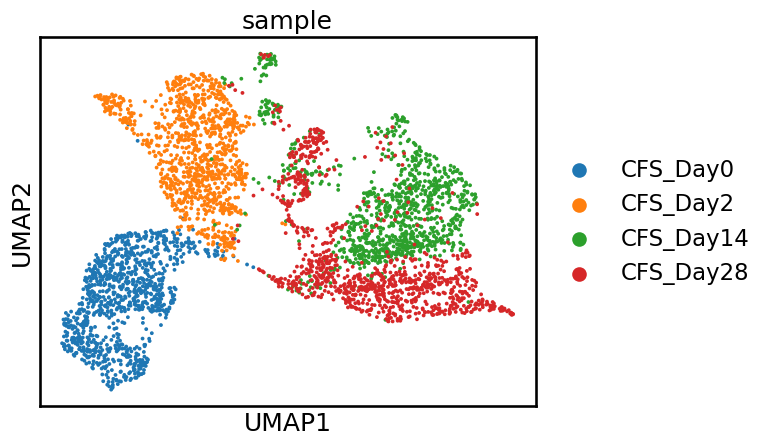

In [7]:
data_is_raw = True
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=False,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=1200,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=51,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata)

sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


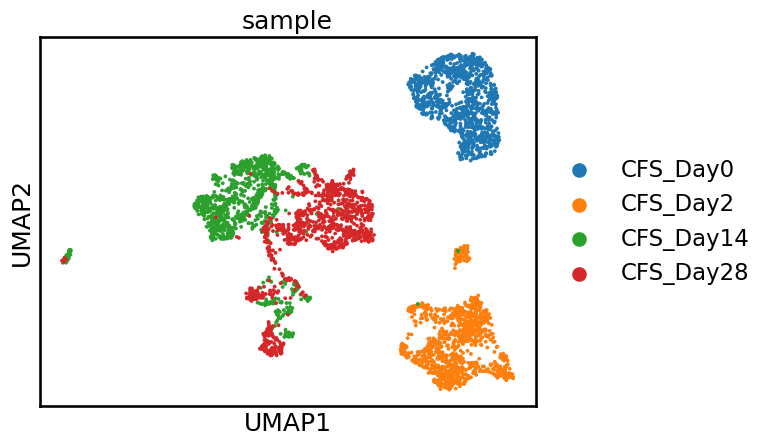

In [5]:
# Normalization and log1p transformation
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
                adata,
                n_top_genes=1200,
                flavor="seurat_v3",
                subset=True,
            )   
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

In [3]:
generated_data = sc.read_h5ad(generated_data_path)

OSError: Unable to synchronously open file (truncated file: eof = 496599040, sblock->base_addr = 0, stored_eof = 677094736)

In [9]:
generated_data

AnnData object with n_obs × n_vars = 4000 × 21091
    obs: 'sample', 'batch'
    var: 'id_in_vocab', 'index'

In [10]:
adata.X

<4000x27622 sparse matrix of type '<class 'numpy.float32'>'
	with 21520637 stored elements in Compressed Sparse Row format>

In [11]:
generated_data.X

array([[32.31625366, 32.00632095, 31.29899597, ..., 32.20664215,
        32.18849564, 32.11319733],
       [32.33176422, 32.00630188, 31.29894257, ..., 32.20660782,
        32.18847275, 32.11316681],
       [32.32527161, 32.00630188, 31.29896927, ..., 32.20661163,
        32.18848038, 32.11316299],
       ...,
       [32.30125427, 32.00632477, 31.29900742, ..., 32.20664597,
        32.18849564, 32.11319351],
       [32.30623245, 32.00632858, 31.29900169, ..., 32.20664215,
        32.18850327, 32.1131897 ],
       [32.31230545, 32.00631714, 31.29898643, ..., 32.20663071,
        32.18849182, 32.11317825]])

In [17]:
from scipy.sparse import csr_matrix

# Check if adata_reconstructed.X is dense
if isinstance(generated_data.X, np.ndarray):
    # Convert the dense array to a sparse matrix
    generated_data.X = csr_matrix(generated_data.X)

In [14]:
generated_data.X

<4000x21091 sparse matrix of type '<class 'numpy.float64'>'
	with 84364000 stored elements in Compressed Sparse Row format>

c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


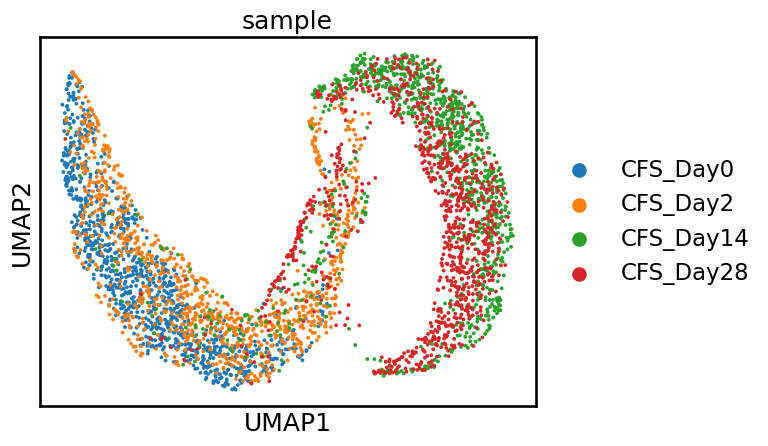

In [18]:
sc.pp.normalize_total(generated_data, target_sum=1e4)
sc.pp.log1p(generated_data)
sc.pp.highly_variable_genes(
                generated_data,
                n_top_genes=1200,
                flavor="seurat_v3",
                subset=True,
            )   
sc.pp.scale(generated_data, max_value=10)
sc.pp.pca(generated_data, svd_solver="arpack")
sc.pp.neighbors(generated_data, n_pcs=40)
sc.tl.umap(generated_data)
sc.pl.umap(generated_data, color="sample")